In [3]:
import scanpy as sc
from scperturb import edist, pairwise_pca_distances, equal_subsampling
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
from tqdm import tqdm
from muon import prot as pt
import matplotlib
import math

from sklearn.metrics import pairwise_distances
from statsmodels.stats.multitest import multipletests

import h5py 

from scipy.stats import zscore
from scipy.cluster.hierarchy import distance, linkage, dendrogram
from scipy.cluster import hierarchy

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300



In [13]:
def cluster_matrix(matrix, how='row', return_order=False, method='centroid'):
    '''
    Hierarchical clustering of a matrix/dataframe. `how` can be 'col', 'row' or 'both' (default: 'row').
    '''
    if how not in ['col', 'row', 'both']:
        raise ValueError('Value for "how" must be row or col.')
    if how!='both':
        M = matrix if how=='row' else matrix.T
        dist = distance.pdist(M)
        link = linkage(dist, method=method)
        dend = dendrogram(link, no_plot=True)
        order = np.array(dend['leaves'], dtype=int)
        if return_order:
            return order
        elif isinstance(matrix, pd.DataFrame):
            return matrix.iloc[order] if how=='row' else matrix.iloc[:, order]
        else:
            return matrix[order] if how=='row' else matrix[:, order]
    else:
        if return_order:
            warn('Returning order when clustering both row and col is not supported.')
        matrix_ = cluster_matrix(matrix, how='row', return_order=False, method=method)
        return cluster_matrix(matrix_, how='col', return_order=False, method=method)
    


In [14]:

rna = sc.read_h5ad("/Users/tessa/Dropbox (HMS)/perturb_resource_tessa/pbmc/rna_only.h5ad")


protein = sc.read_h5ad("/Users/tessa/Dropbox (HMS)/perturb_resource_tessa/pbmc/protein_only.h5ad")


In [5]:
f = h5py.File("/Users/tessa/Dropbox (HMS)/perturb_resource_tessa/pbmc/pbmc_multimodal.h5seurat", 'r')
umap = f["reductions"]['umap']['cell.embeddings'][:,:]
cellids = f['cell.names'][:]
umap = pd.DataFrame(np.transpose(umap), index = cellids)
umap.index = umap.index.astype('str')

In [30]:
rna.obsm['X_umap'] = umap.values

In [31]:
rna = rna[(rna.obs['celltype.l2'] != "Eryth") & (rna.obs['celltype.l2'] != "ASDC" ),:]



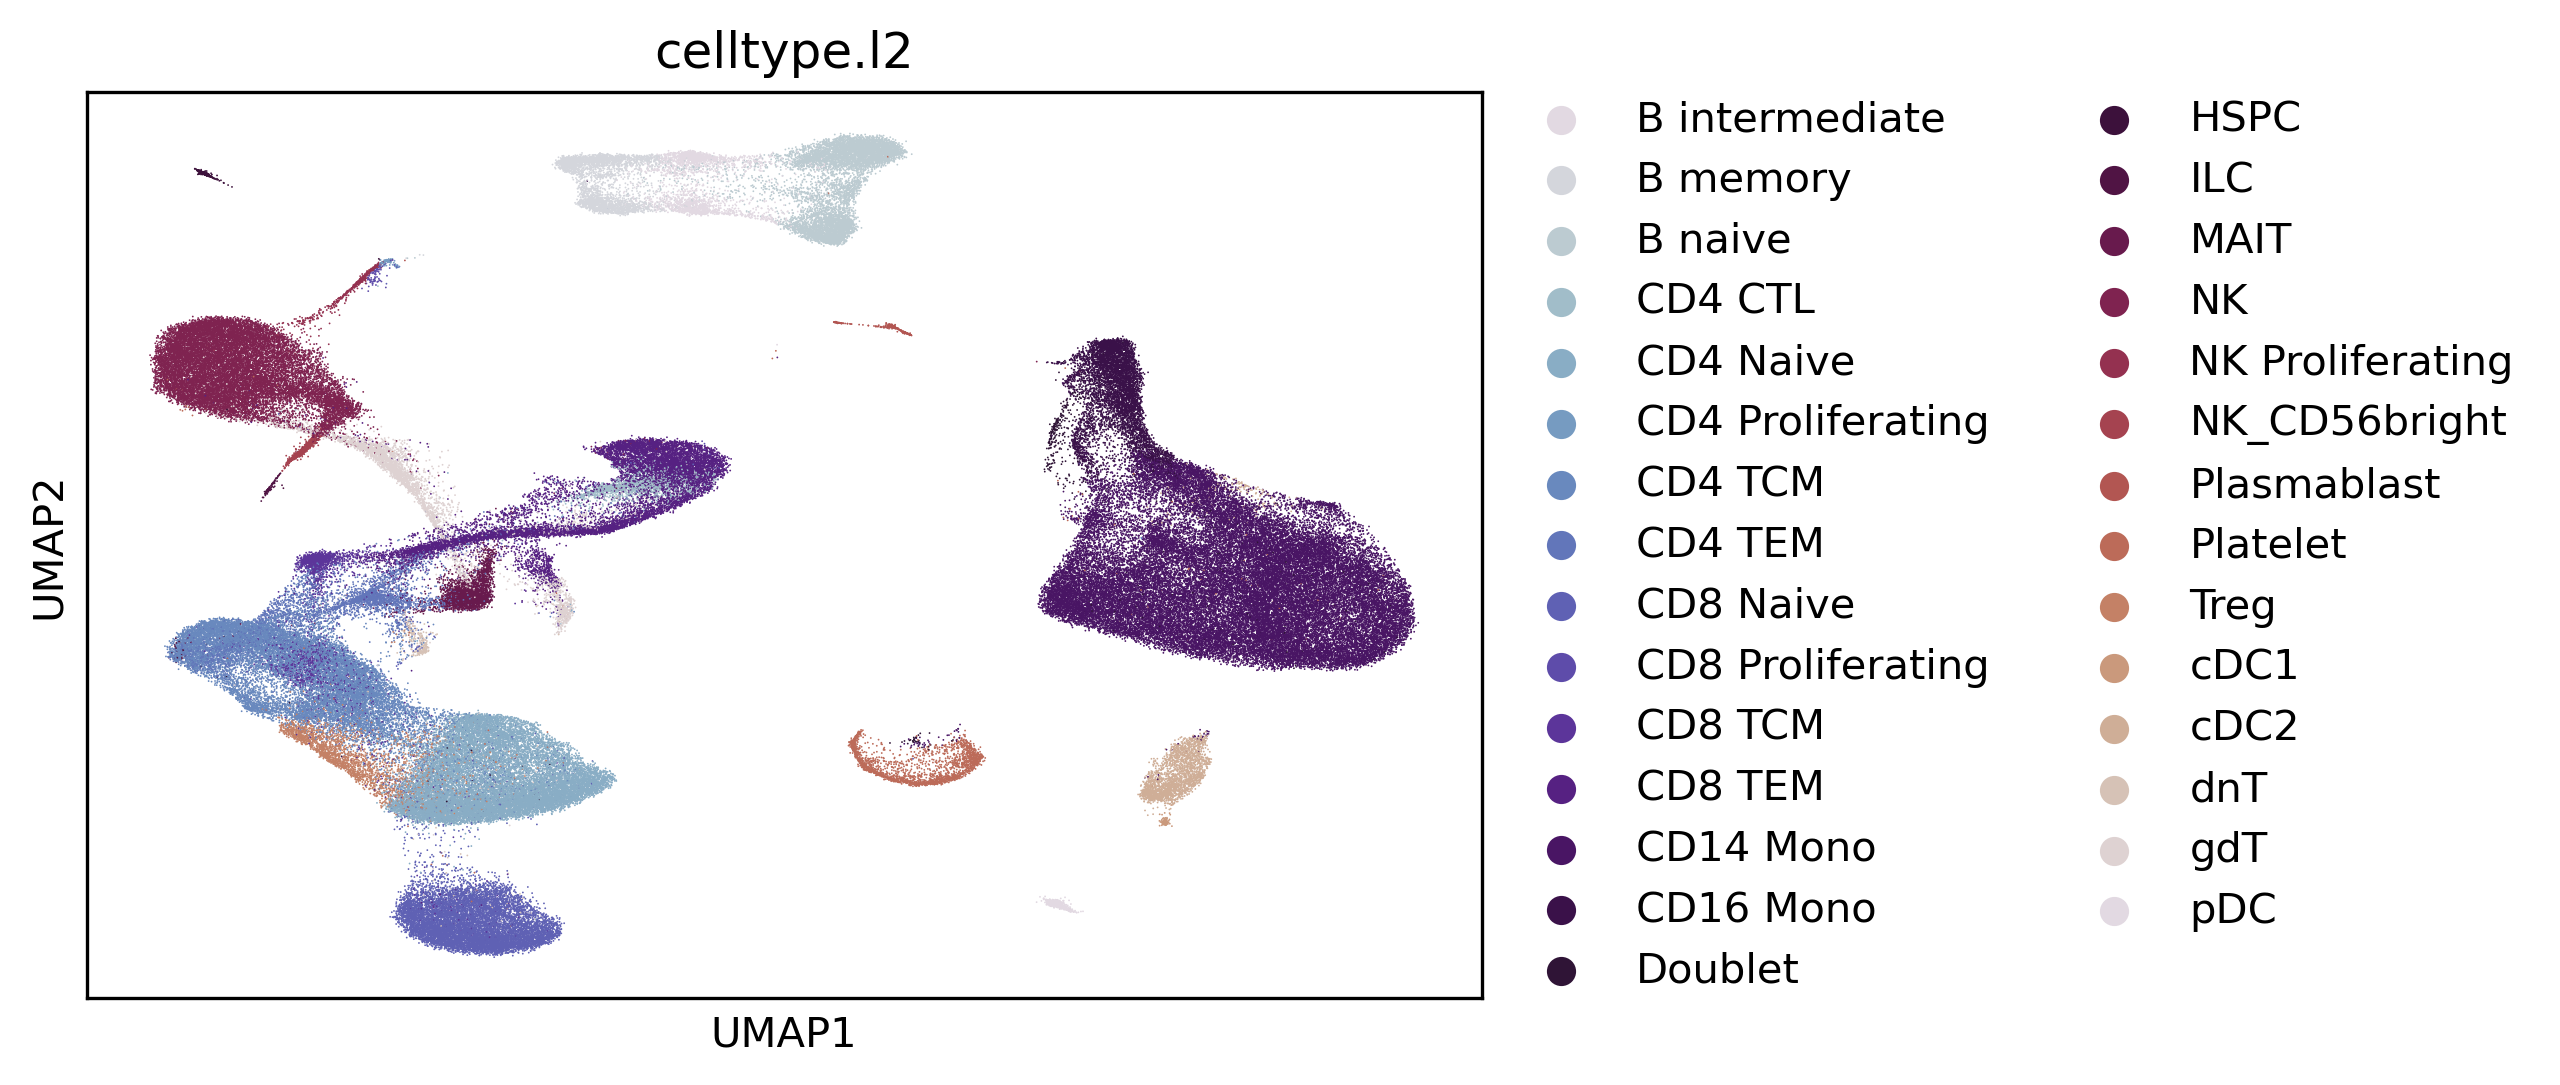

In [61]:
sc.pl.umap(rna, color = "celltype.l2", palette = 'twilight', save = "_full")

In [35]:
adata = equal_subsampling(rna, obs_key="celltype.l2", N_min=91)

In [36]:
adata.layers['counts'] = adata.X.copy()

# basic qc and pp
sc.pp.filter_cells(adata, min_counts=1000)
sc.pp.normalize_per_cell(adata)
sc.pp.filter_genes(adata, min_cells=50)
sc.pp.filter_genes(adata, min_cells=3)  # sanity cleaning

n_var_max = 2000  # max total features to select
sc.pp.highly_variable_genes(adata, n_top_genes=n_var_max, subset=False, flavor='seurat_v3', layer='counts')
sc.pp.log1p(adata)

sc.pp.pca(adata, use_highly_variable=True)
sc.pp.neighbors(adata)

adata.uns['processed'] = True

In [37]:
adata.obs['celltype'] = adata.obs['celltype.l2']
adata = adata[adata.obs['celltype']!="Doublet",:]


In [38]:
pwd_rna = pairwise_pca_distances(adata, 'celltype', obsm_key='X_pca', dist='sqeuclidean', verbose=True)


100%|███████████████████████████████████████████| 28/28 [00:01<00:00, 27.80it/s]


In [39]:
estats_rna = edist(adata, obs_key='celltype', obsm_key='X_pca', pwd=pwd_rna, dist='sqeuclidean')

/var/folders/_j/9fb8r7hn7zx13rt7glsw4j3h0000gn/T/ipykernel_14553/4294160403.py:12: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = hierarchy.linkage(ed, 'single')


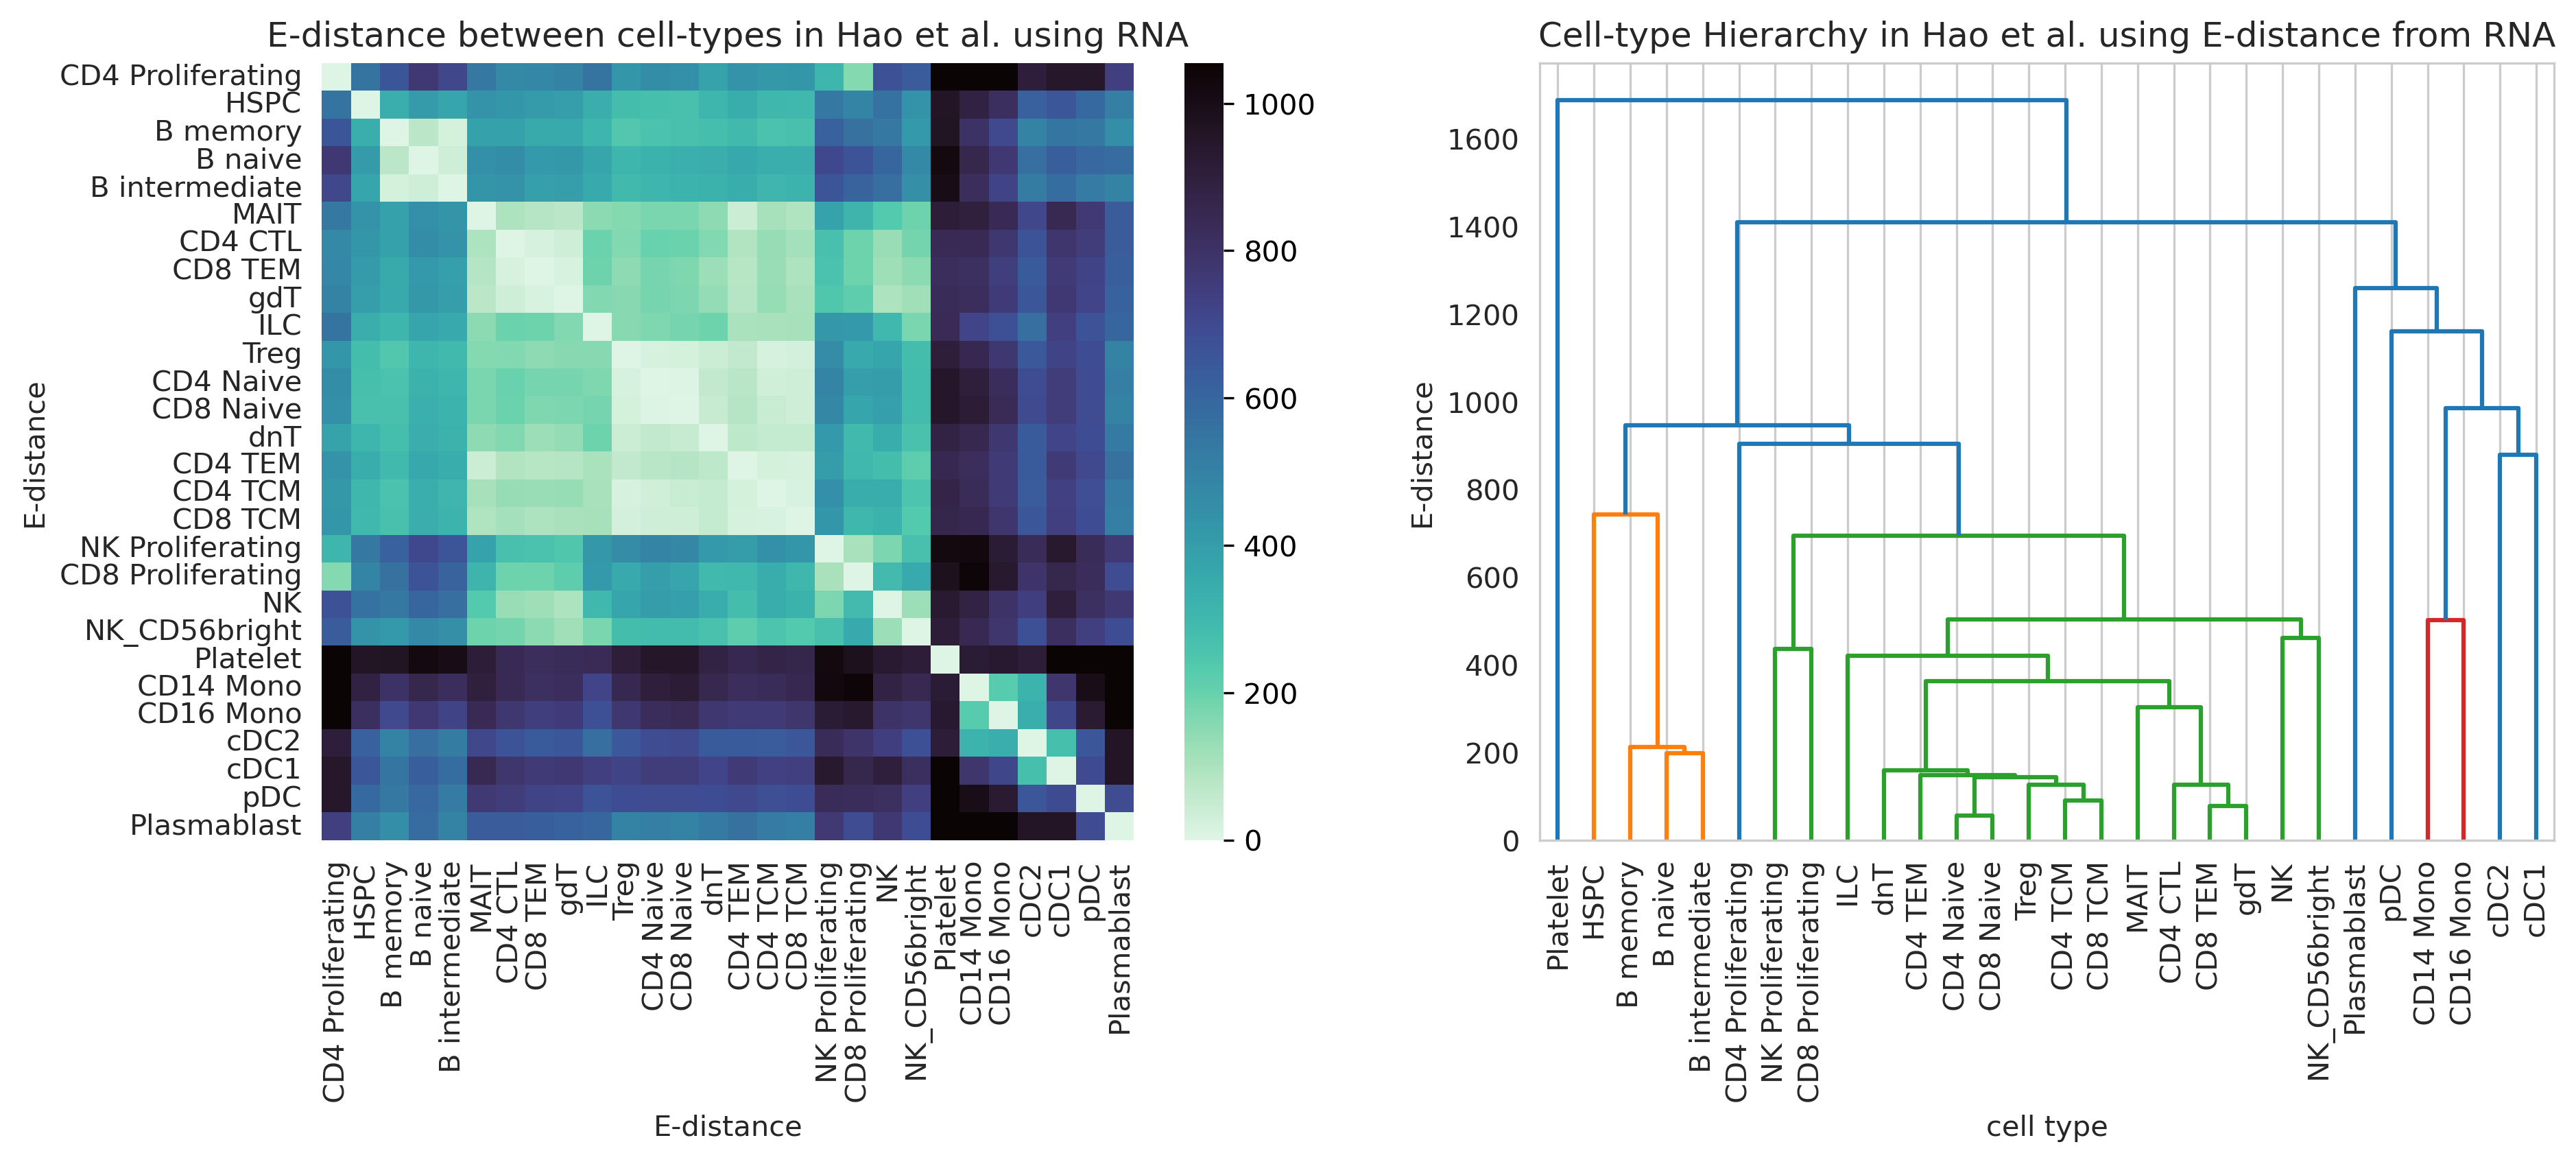

In [63]:

ed=estats_rna
with sns.axes_style('whitegrid'):
    fig, axs = plt.subplots(1, 2, figsize=[7*2,5])

ax = axs[0]
sns.heatmap(cluster_matrix(ed, "both"), robust=True, cmap = sns.cm.mako_r, xticklabels=True, yticklabels=True, ax=ax)
ax.set_title('E-distance between cell-types in Hao et al. using RNA')
ax.set_xlabel('E-distance')
ax.set_ylabel('E-distance')

ax=axs[1]
Z = hierarchy.linkage(ed, 'single')
dn = hierarchy.dendrogram(Z, labels=ed.columns, color_threshold=800, ax=ax)
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.ylabel('E-distance')
plt.xlabel('cell type')
plt.title('Cell-type Hierarchy in Hao et al. using E-distance from RNA')
#plt.show()
plt.savefig("pbmc_RNA_HaoHao.pdf",bbox_inches="tight")

In [43]:
protein = sc.read_h5ad("/Users/tessa/Dropbox (HMS)/perturb_resource_tessa/pbmc/protein_only.h5ad")

In [44]:
protein = protein[protein.obs_names.isin(adata.obs_names),:]
pt.pp.clr(protein)
sc.pp.log1p(protein)
sc.pp.pca(protein)

/opt/anaconda3/envs/scvi/lib/python3.9/site-packages/muon/_prot/preproc.py:214: UserWarning: adata.X is sparse but not in CSC format. Converting to CSC.
  warn("adata.X is sparse but not in CSC format. Converting to CSC.")
/opt/anaconda3/envs/scvi/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:373: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/opt/anaconda3/envs/scvi/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:373: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  view_to_actual(adata)


In [45]:

protein.obs['celltype'] = protein.obs['celltype.l2']
protein = protein[protein.obs['celltype']!="Doublet",:]

pwd_prot = pairwise_pca_distances(protein, 'celltype', obsm_key='X_pca', dist='sqeuclidean', verbose=True)


100%|███████████████████████████████████████████| 28/28 [00:00<00:00, 68.14it/s]


In [46]:
estats_prot = edist(protein, obs_key='celltype', obsm_key='X_pca', pwd=pwd_prot, dist='sqeuclidean')


/var/folders/_j/9fb8r7hn7zx13rt7glsw4j3h0000gn/T/ipykernel_14553/1560121542.py:13: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = hierarchy.linkage(ed, 'single')


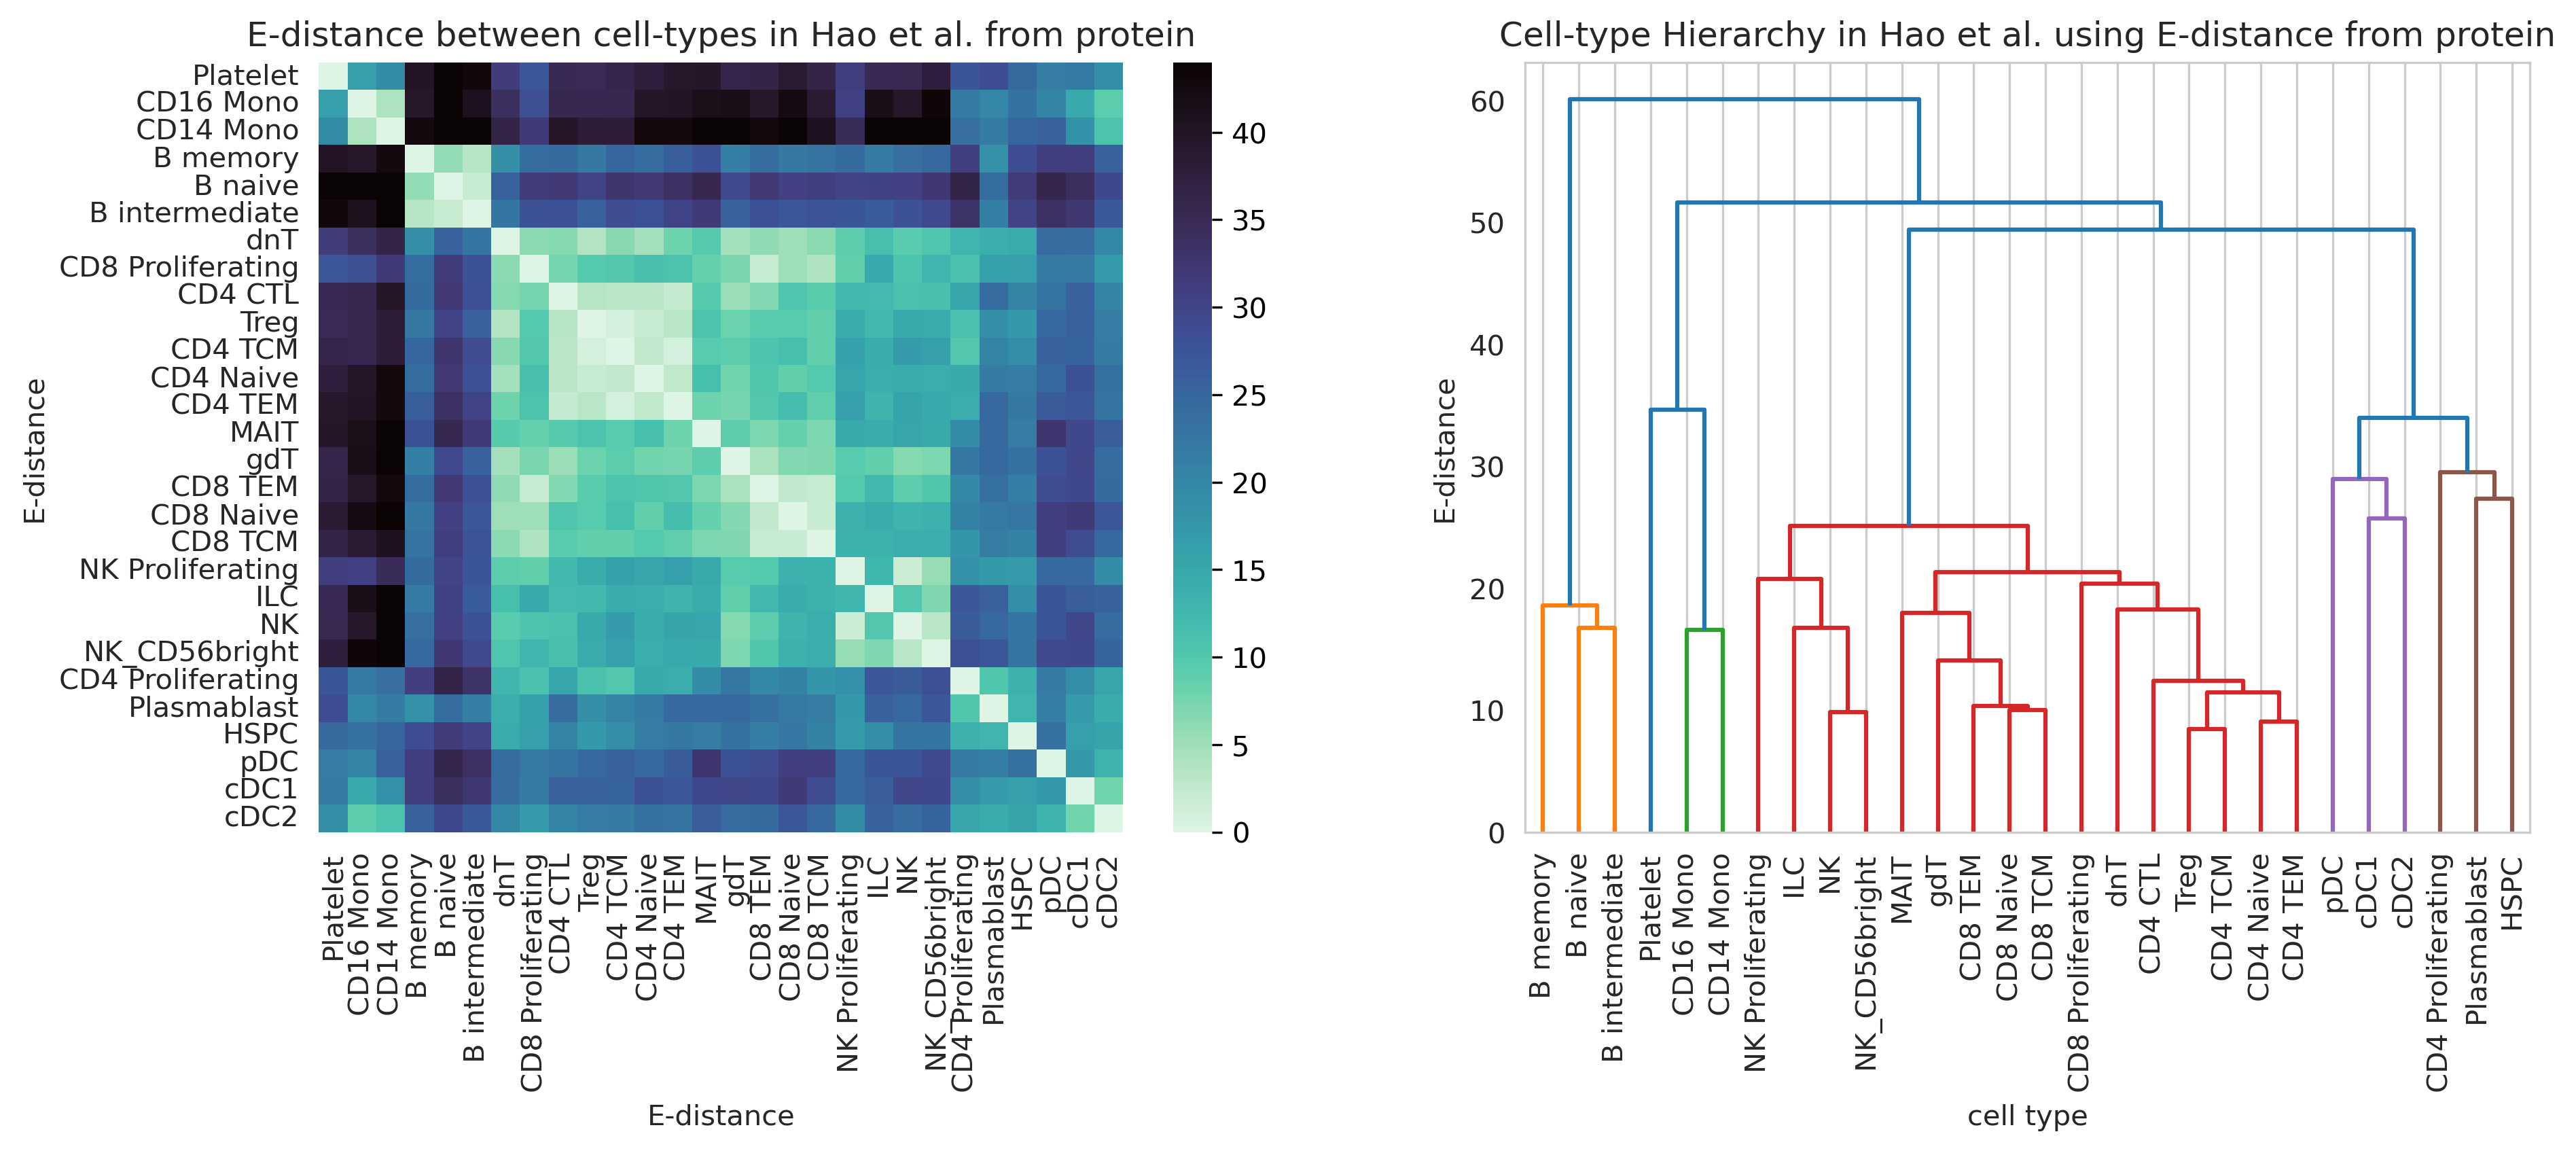

In [64]:
ed=estats_prot

with sns.axes_style('whitegrid'):
    fig, axs = plt.subplots(1, 2, figsize=[7*2,5])

ax = axs[0]
sns.heatmap(cluster_matrix(ed, "both"), robust=True, cmap = sns.cm.mako_r, xticklabels=True, yticklabels=True, ax=ax)
ax.set_title('E-distance between cell-types in Hao et al. from protein')
ax.set_xlabel('E-distance')
ax.set_ylabel('E-distance')

ax=axs[1]
Z = hierarchy.linkage(ed, 'single')
dn = hierarchy.dendrogram(Z, labels=ed.columns, color_threshold=30, ax=ax)
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.ylabel('E-distance')
plt.xlabel('cell type')
plt.title('Cell-type Hierarchy in Hao et al. using E-distance from protein')
#plt.show()
plt.savefig("pbmc_protein_HaoHao.pdf", bbox_inches="tight")

In [48]:
adata.obsm['RNA_PCA']  = adata.obsm["X_pca"]# PCA of the RNA modality
adata.obsm['ADT_PCA'] = protein.obsm["X_pca"]

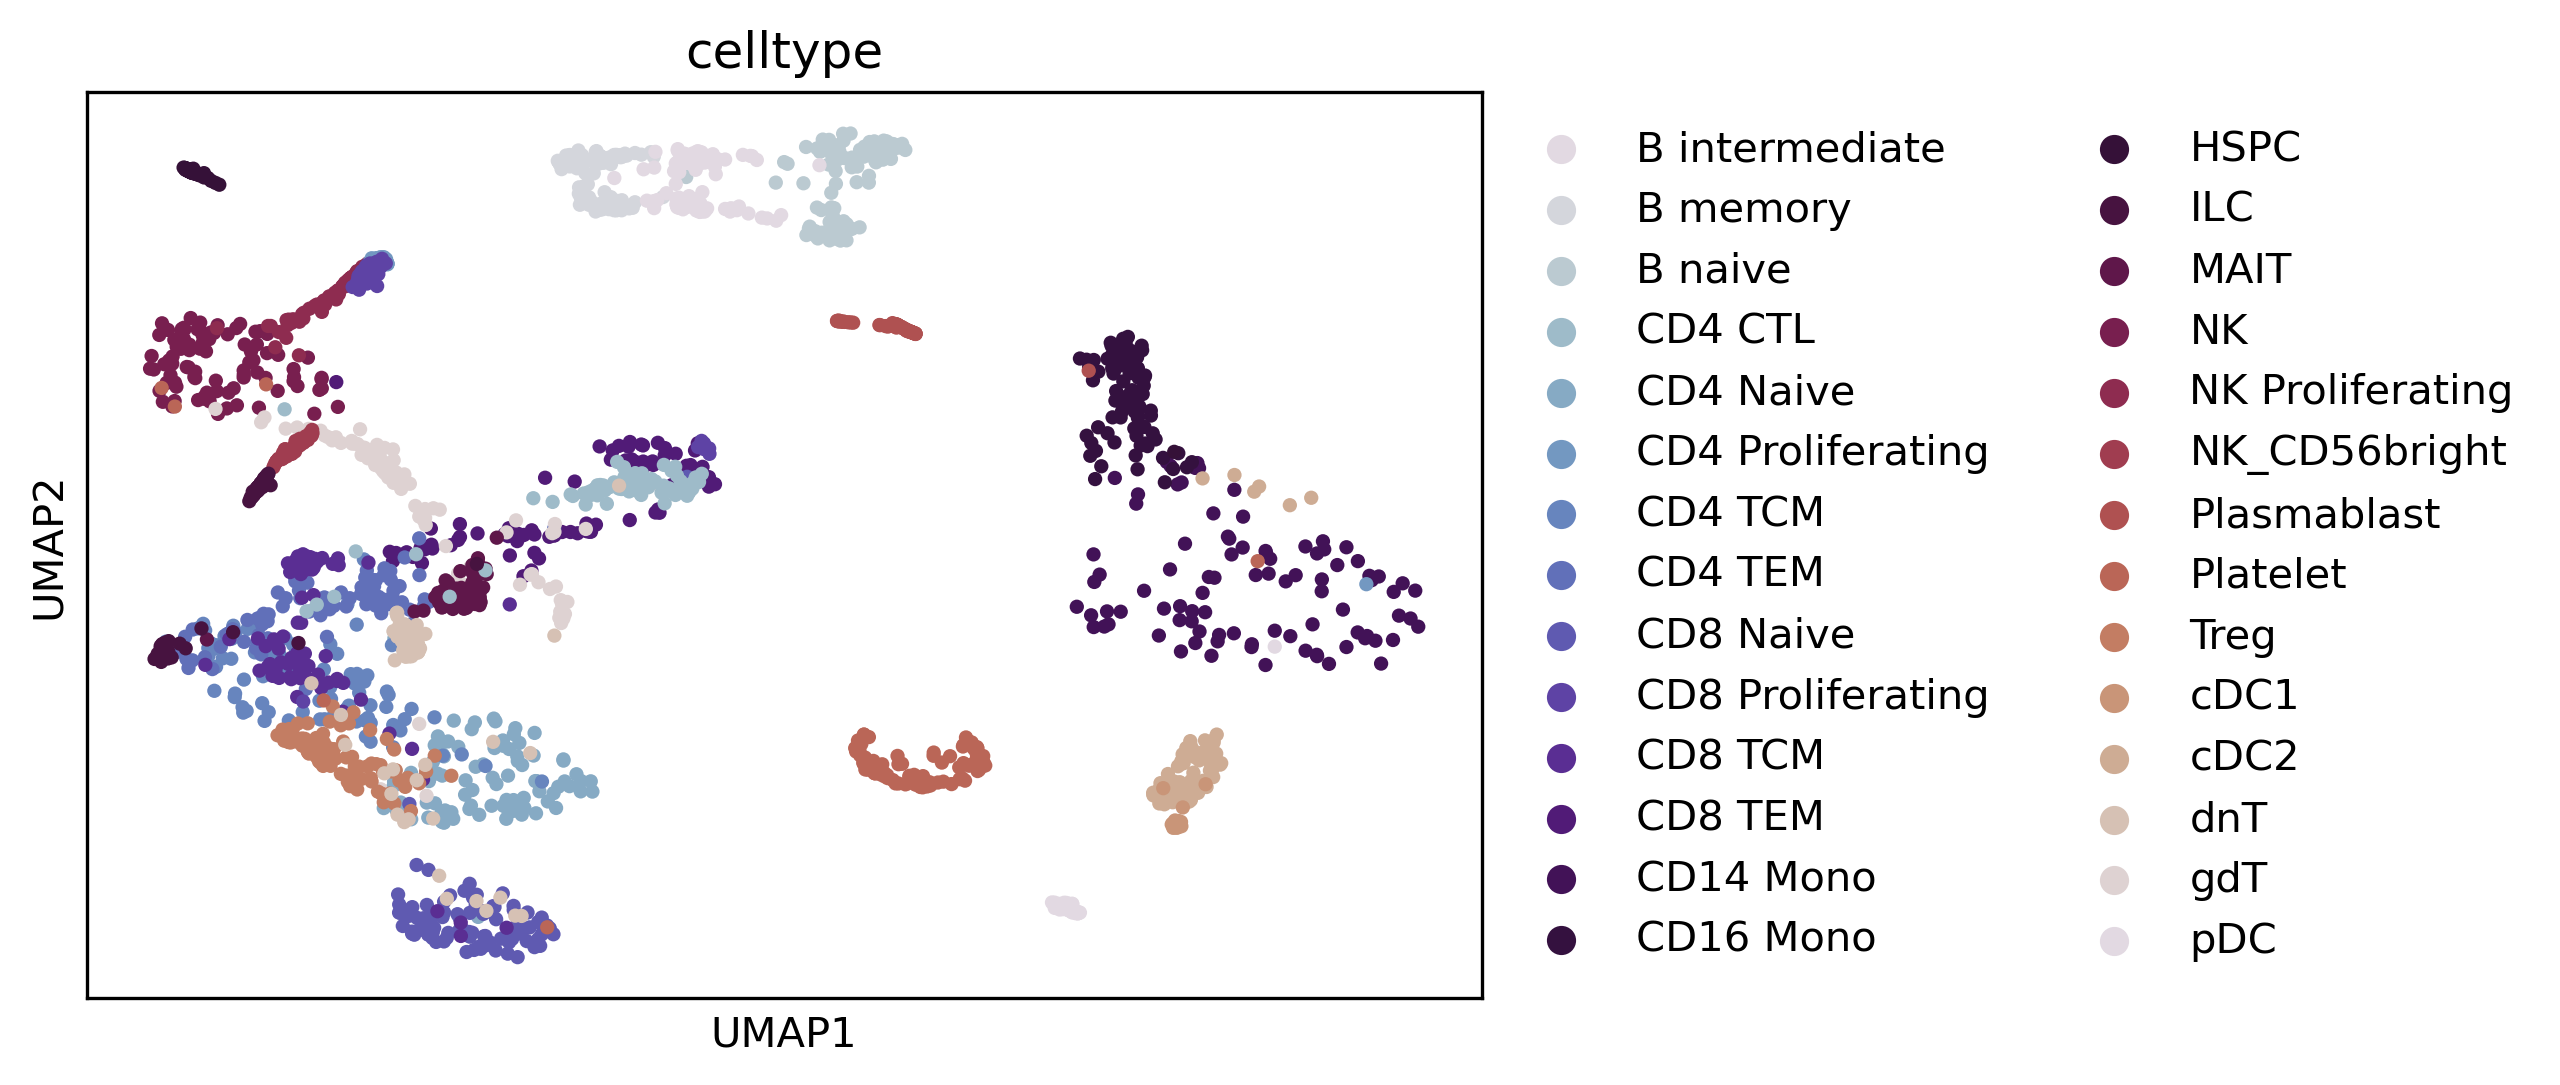

In [60]:
sc.pl.umap(adata, color="celltype", palette = "twilight", save = "_subset")